# Projet Detection d'object de jonglerie

## Importation des packages

In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

import fiftyone as fo

import pandas as pd
import ast
import shutil
from PIL import Image
import json
import random
import time
import datetime
import optuna
from torchvision.transforms import Normalize
import sys

c:\Users\mcossin\.conda\envs\obj_detect\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://github.com/pytorch/vision/tree/main/references/detection
from references import transforms, utils, engine, train
from references.utils import collate_fn
from references.engine import train_one_epoch, evaluate

## COCO Format 

Transformation des données de Deeplabcut au format COCO

In [ ]:
labeled_data_path = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_youtube-sebastien-2024-02-05\labeled-data"

In [ ]:
csv_path = []
for item in os.listdir(labeled_data_path):
   
    folder_path = os.path.join(labeled_data_path, item)

    if os.path.isdir(folder_path):
        
        if not item.endswith("_labeled"):

            for idx,it in enumerate(os.listdir(folder_path)):

                if it.endswith("csv"):

                    csv_path.append(os.path.join(folder_path, it))

In [ ]:
csv1 = pd.read_csv(csv_path[0])
csv2 = pd.read_csv(csv_path[3])

In [ ]:
csv1

In [ ]:
csv2

In [ ]:
csv1 = csv1.drop(csv1.index[:3])
csv2 = csv2.drop(csv2.index[:3])

#### Change le nom des frame pour simplifier l'addition de frames depuis différent dossier

In [ ]:
def change_name(dataframe, dossier_images_source, dossier_images_destination,num_csv, idx):
    
    if not os.path.exists(dossier_images_destination):
        os.makedirs(dossier_images_destination)

    for index, row in dataframe.iterrows():
        
        #if index < 3:
        #    continue

        nom_fichier = row['Unnamed: 2']
        video_origin = row['Unnamed: 1']

        if pd.isna(nom_fichier):
            continue

        chemin_source = os.path.join(dossier_images_source, nom_fichier)

        nouveau_nom_fichier = f"{video_origin}_{index-3 + idx}.png"

        chemin_destination = os.path.join(dossier_images_destination, nouveau_nom_fichier)

        shutil.copy(chemin_source, chemin_destination)
        
        df_copie = dataframe.copy()

        dataframe.at[index, 'Unnamed: 2'] = nouveau_nom_fichier

    idx = index + idx
    #idx = index-3 + idx

    dataframe.to_csv(os.path.join(dossier_images_destination, f"annotations_{num_csv}.csv"), index=False)

    return(idx)

In [ ]:
dossier_images_destination = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_detection\New_Dataset\images"
idx=0

for item in os.listdir(labeled_data_path):
   
    folder_path = os.path.join(labeled_data_path, item)

    if os.path.isdir(folder_path):
        
        if item == csv1.iloc[3]["Unnamed: 1"]:
            index = change_name(csv1, folder_path, dossier_images_destination,1,idx)
            idx = index
        if item == csv2.iloc[3]["Unnamed: 1"]:    
            index2 = change_name(csv2, folder_path, dossier_images_destination,2,idx)

In [ ]:
## Merge les nouveaux csv
csv = pd.concat([csv1, csv2], ignore_index=True)
print(csv)

#### Bounding Box

In [ ]:
def form_bbox(clubhead, clubmiddle, clubbottom, pixel_box):

    if (not np.isnan(clubhead[0]) and not np.isnan(clubhead[1])) and (not np.isnan(clubmiddle[0]) and not np.isnan(clubmiddle[1])) and (not np.isnan(clubbottom[0]) and not np.isnan(clubbottom[1])):
        
        bbox_orig = [min(clubhead[0], clubmiddle[0], clubbottom[0]),
                min(clubhead[1], clubmiddle[1], clubbottom[1]),
                max(clubhead[0], clubmiddle[0], clubbottom[0]),
                max(clubhead[1], clubmiddle[1], clubbottom[1])]
        
        width = round(bbox_orig[2] - bbox_orig[0])
        height = round(bbox_orig[3] - bbox_orig[1])

        bbox = [max(round(bbox_orig[0] - pixel_box),0), 
                max(round(bbox_orig[1] - pixel_box),0), 
                max(round(width + 2*pixel_box),0), 
                max(round(height + 2*pixel_box),0)]
        
    elif (not np.isnan(clubhead[0]) and not np.isnan(clubhead[1])) and (not np.isnan(clubmiddle[0]) and not np.isnan(clubmiddle[1])):

        bbox_orig = [min(clubhead[0], clubmiddle[0]),
                min(clubhead[1], clubmiddle[1]),
                max(clubhead[0], clubmiddle[0]),
                max(clubhead[1], clubmiddle[1])]
        
        width = round(bbox_orig[2] - bbox_orig[0])
        height = round(bbox_orig[3] - bbox_orig[1])

        bbox = [max(round(bbox_orig[0] - pixel_box),0), 
                max(round(bbox_orig[1] - pixel_box),0), 
                max(round(width + 2*pixel_box),0), 
                max(round(height + 2*pixel_box),0)]
            
    elif (not np.isnan(clubmiddle[0]) and not np.isnan(clubmiddle[1])) and (not np.isnan(clubbottom[0]) and not np.isnan(clubbottom[1])):

        bbox_orig = [min(clubmiddle[0], clubbottom[0]),
                min(clubmiddle[1], clubbottom[1]),
                max(clubmiddle[0], clubbottom[0]),
                max(clubmiddle[1], clubbottom[1])]

        width = round(bbox_orig[2] - bbox_orig[0])
        height = round(bbox_orig[3] - bbox_orig[1])

        bbox = [max(round(bbox_orig[0] - pixel_box),0), 
                max(round(bbox_orig[1] - pixel_box),0), 
                max(round(width + 2*pixel_box),0), 
                max(round(height + 2*pixel_box),0)] 
               
    elif (not np.isnan(clubhead[0]) and not np.isnan(clubhead[1])) and (not np.isnan(clubbottom[0]) and not np.isnan(clubbottom[1])):

        bbox_orig = [min(clubhead[0], clubbottom[0]),
                min(clubhead[1], clubbottom[1]),
                max(clubhead[0], clubbottom[0]),
                max(clubhead[1], clubbottom[1])]

        width = round(bbox_orig[2] - bbox_orig[0])
        height = round(bbox_orig[3] - bbox_orig[1])

        bbox = [max(round(bbox_orig[0] - pixel_box),0), 
                max(round(bbox_orig[1] - pixel_box),0), 
                max(round(width + 2*pixel_box),0), 
                max(round(height + 2*pixel_box),0)]
    else:

        if (not np.isnan(clubhead[0]) and not np.isnan(clubhead[1])):

            bbox_orig = [clubhead[0] - pixel_box, clubhead[1] - pixel_box, clubhead[0] + pixel_box, clubhead[1] + pixel_box]

            width = round(bbox_orig[2] - bbox_orig[0])
            height = round(bbox_orig[3] - bbox_orig[1])
            bbox = [max(round(bbox_orig[0] - pixel_box),0), 
                max(round(bbox_orig[1] - pixel_box),0), 
                max(round(width + 2*pixel_box),0), 
                max(round(height + 2*pixel_box),0)]
        
        elif (not np.isnan(clubmiddle[0]) and not np.isnan(clubmiddle[1])):

            bbox_orig = [clubmiddle[0] - pixel_box, clubmiddle[1] - pixel_box, clubmiddle[0] + pixel_box, clubmiddle[1] + pixel_box]

            width = round(bbox_orig[2] - bbox_orig[0])
            height = round(bbox_orig[3] - bbox_orig[1])
            bbox = [max(round(bbox_orig[0] - pixel_box),0), 
                max(round(bbox_orig[1] - pixel_box),0), 
                max(round(width + 2*pixel_box),0), 
                max(round(height + 2*pixel_box),0)]
            
        elif (not np.isnan(clubbottom[0]) and not np.isnan(clubbottom[1])):

            bbox_orig = [clubbottom[0] - pixel_box, clubbottom[1] - pixel_box, clubbottom[0] + pixel_box, clubbottom[1] + pixel_box]

            width = round(bbox_orig[2] - bbox_orig[0])
            height = round(bbox_orig[3] - bbox_orig[1])
            bbox = [max(round(bbox_orig[0] - pixel_box),0), 
                max(round(bbox_orig[1] - pixel_box),0), 
                max(round(width + 2*pixel_box),0), 
                max(round(height + 2*pixel_box),0)]  
            
        else :
            bbox = [0,0,0,0]
            
    return bbox


#### Remplissable des données dans le nouveau json

In [ ]:
def fill_annotations_images(dataframe,index_keypoint,index_image):
    annotations = []
    images = []
    index_key = index_keypoint
    index_image = index_image

    for index, row in dataframe.iterrows():

        ################################### Fill images part 
        image_name = row['Unnamed: 2']
        image_id = index  +index_image
        #image_id = index - 3 +index_image
        image_path = os.path.join(r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_detection\New_Dataset\images",image_name)
        img = Image.open(image_path)
        width, height = img.size

        image = {}
        image = {"id": image_id,"file_name" : image_name, "width":width, "height":height, "url": image_path,"group" : 0}
        
        images.append(image)

        ################################### Fill annotations part 
        keypoints_ranges = [(3, 8), (9, 14), (15, 20)]

        for start, end in keypoints_ranges:

            keypoints = []
            annotation = {}

            annotation = {"id": index_key, "image_id": image_id, "category_id": 1}

            for j in range(start, end, 2):
                if  pd.notna(row.iloc[j]) and pd.notna(row.iloc[j + 1]):
                    x_value = float(row.iloc[j])
                    y_value = float(row.iloc[j + 1])
                    keypoints.extend([x_value, y_value, 2])  # Assuming all keypoints are labeled
                else:
                    keypoints.extend([np.nan, np.nan, np.nan])

            clubhead = (keypoints[0],keypoints[1])
            clubmiddle = (keypoints[3],keypoints[4])
            clubbottom = (keypoints[6],keypoints[7])

            if clubhead ==(np.nan,np.nan) and clubmiddle ==(np.nan,np.nan) and clubbottom ==(np.nan,np.nan):
                pass 
            else :
                annotation["keypoints"] = keypoints
                
                bbox = form_bbox(clubhead, clubmiddle, clubbottom, 7) ## rajoute 10 pixels sur les cotés

                annotation["bbox"] = bbox

                if sum(1 for k in range(len(keypoints)) if (keypoints[k] and keypoints[k] != 2)) == 2 or sum(1 for k in range(len(keypoints)) if (keypoints[k] and keypoints[k] != 2)) == 0 :
                    annotation["iscrowd"]=0
                else:
                    annotation["iscrowd"]=1

                annotation["num_keypoints"] = sum(1 for k in range(len(keypoints)) if (keypoints[k] and keypoints[k] != 2))

                annotations.append(annotation)

                index_key +=1

    return images, annotations

In [ ]:
index_keypoint = 0
index_image = 0 

images,annotations = fill_annotations_images(csv,index_keypoint,index_image)


In [ ]:
info = [
    {
        "description": "Critac Project Dataset",
        "version": "1.0",
        "year": 2024,
        "contributor": "Sebastien",
        "date_created": "2024/02/27"
    }
]

In [ ]:
categories = [
    {
        "supercategory": "Object",
        "id": 1,
        "name": "Club",
        "keypoints": [
            "Clubhead","Clubmiddle","Clubbottom"
        ],
        "skeleton": [
            [0,1],[1,2],[0,2]
        ]
    }
]

In [ ]:
data = {
    "info": info[0],
    "categories": categories, 
    "images": images,
    "annotations": annotations,
}

output_file = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_detection\New_Dataset\annotations"
json_file_path = os.path.join(output_file,'annotations.json')

if not os.path.exists(output_file):
    os.makedirs(output_file)

with open(json_file_path, "w") as json_file:
    json.dump(data, json_file, indent=4)

Avant de split je modifie le fichier annotations.json pour ajouter l'attribut group correspond si les keypoints sont proches et forme un group. group : 0 signifie aue les club sont bien espacé. group : 1 siginifie qu'ils sont proches.

#### Melange et crée les 3 fichiers json train, valid et test

In [ ]:
def split(json_path,output,pourcent_train,pourcent_val):
    with open(json_path, "r") as json_file:
        data = json.load(json_file)

    random.shuffle(data["images"])

    total_images = len(data["images"])

    group1_images = [img for img in data["images"] if img["group"] == 1]
    group1_count = len(group1_images)
    print("Nombre de frame avec l'attribut group à 1 :", group1_count)

    group0_images = [img for img in data["images"] if img["group"] == 0]
    group0_count = len(group0_images)
    print("Nombre de frame avec l'attribut group à 0 :", group0_count)

    group1_train_size = int(group1_count * pourcent_train)
    group1_valid_size = int(group1_count * pourcent_val)

    train_size = int(total_images * pourcent_train)
    valid_size = int(total_images * pourcent_val)

    #train_data = {"categories": data["categories"], "info": data["info"], "images": data["images"][:train_size], "annotations": []}
    #valid_data = {"categories": data["categories"], "info": data["info"], "images": data["images"][train_size:train_size+valid_size], "annotations": []}
    #test_data = {"categories": data["categories"], "info": data["info"], "images": data["images"][train_size+valid_size:], "annotations": []}

    train_data = {"categories": data["categories"], "info": data["info"], "images": [], "annotations": []}
    valid_data = {"categories": data["categories"], "info": data["info"], "images": [], "annotations": []}
    test_data = {"categories": data["categories"], "info": data["info"], "images": [], "annotations": []}

    # Ajouter les images group1 aux données de train et de validation
    train_data["images"].extend(group1_images[:group1_train_size])
    valid_data["images"].extend(group1_images[group1_train_size:group1_train_size + group1_valid_size])
    test_data["images"].extend(group1_images[group1_train_size + group1_valid_size:])

    # Ajouter le reste des images aux données de train, validation et test
    non_group1_images = [img for img in data["images"] if img["group"] != 1]
    train_data["images"].extend(non_group1_images[:train_size - group1_train_size])
    valid_data["images"].extend(non_group1_images[train_size - group1_train_size:train_size + valid_size - group1_train_size - group1_valid_size])
    test_data["images"].extend(non_group1_images[train_size + valid_size - group1_train_size - group1_valid_size:])

    group1_train = [img for img in train_data["images"] if img["group"] == 1]
    group1_valid = [img for img in valid_data["images"] if img["group"] == 1]
    group1_test = [img for img in test_data["images"] if img["group"] == 1]
    group0_train = [img for img in train_data["images"] if img["group"] == 0]
    group0_valid = [img for img in valid_data["images"] if img["group"] == 0]
    group0_test = [img for img in test_data["images"] if img["group"] == 0]

    print("Nombre de frame avec l'attribut group à 1 dans le split train :", len(group1_train))
    print("Nombre de frame avec l'attribut group à 1 dans le split valid :", len(group1_valid))
    print("Nombre de frame avec l'attribut group à 1 dans le split test :", len(group1_test))
    print("Nombre de frame avec l'attribut group à 0 dans le split train :", len(group0_train))
    print("Nombre de frame avec l'attribut group à 0 dans le split valid :", len(group0_valid))
    print("Nombre de frame avec l'attribut group à 0 dans le split test :", len(group0_test))

    for annotation in data["annotations"]:
        if annotation["image_id"] in [image["id"] for image in train_data["images"]]:
            train_data["annotations"].append(annotation)
        elif annotation["image_id"] in [image["id"] for image in valid_data["images"]]:
            valid_data["annotations"].append(annotation)
        else:
            test_data["annotations"].append(annotation)

    if not os.path.exists(output):
        os.makedirs(output)

    with open(os.path.join(output, "train.json"), "w") as train_json_file:
        json.dump(train_data, train_json_file, indent=4)

    with open(os.path.join(output, "valid.json"), "w") as valid_json_file:
        json.dump(valid_data, valid_json_file, indent=4)

    with open(os.path.join(output, "test.json"), "w") as test_json_file:
        json.dump(test_data, test_json_file, indent=4)

In [ ]:
json_file = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_detection\New_Dataset\annotations\annotations.json"
output = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_detection\New_Dataset\annotations"
pourcent_train = 0.7
pourcent_val = 0.15

split(json_file,output,pourcent_train,pourcent_val)   


## Visualisation Dataset

In [ ]:
labels_path = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_detection\Dataset4\annotations\test.json"
data_path = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_detection\Dataset4\images"

# https://docs.voxel51.com/user_guide/dataset_creation/datasets.html#loading-datasets-from-disk
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
)

In [ ]:
session = fo.launch_app(dataset)

## Augmentation de donnée

In [3]:
crop_size = 700

def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=0.5),  # Random change of brightness & contrast
            A.HorizontalFlip(p=0.5),  # Randomly flips the input horizontally
            A.VerticalFlip(p=0.5),  # Randomly flips the input vertically
            A.CenterCrop (crop_size, crop_size, always_apply=False, p=1.0),
            A.GaussNoise(var_limit=(10, 50), mean=0, p=0.5),
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'),  # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='coco', label_fields=['bboxes_labels'])  # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )
    

In [4]:
class ClassDataset(Dataset):
    def __init__(self, root, jsonfile, transform=None, demo=False):
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.annotations_file = os.path.join(root, "annotations", jsonfile)  # Chemin vers le fichier JSON des annotations

        with open(self.annotations_file) as f:
            self.annotations = json.load(f)

        self.imgs_files = [images["file_name"] for images in self.annotations["images"]]

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        for image_info in self.annotations["images"]:
            if image_info["file_name"] == self.imgs_files[idx]:
                image_id = image_info["id"]
                break

        annotations = []
        for annotation_info in self.annotations["annotations"]:
            if annotation_info["image_id"] == image_id:
                annotations.append(annotation_info)

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        ### taille des images
        img_height, img_width = img_original.shape[:2]

        ### Recupere les boites dans le format coco x,y,w,h et les keypoints
        bboxes_original = []
        keypoints_originals = []
        iscrowd = []
        for annotation in annotations:

            bbox = annotation["bbox"]
            bboxes_original.append(bbox)
            iscrowd.append(annotation["iscrowd"])

            kp = annotation["keypoints"]
            keypoints_originals.append(kp)

        #### Crée une liste avec les keypoints dans le format coco pour la transformation
        #### et crée une liste dans le format x1, y1, x2, y2 pour la visualisation
        bboxes_original_xywh = []
        bboxes_original_xy = []
        for bbox in bboxes_original:
            x1, y1, w, h = bbox
            bboxes_original_xywh.append([x1,y1,w,h])
            bboxes_original_xy.append([min(max(x1,0),img_width), min(max(y1,0),img_height), min(max(w+x1,0),img_width), min(max(h+y1,0),img_height)])

        #### Convertis le format coco des annotations keypoints [x,y,visibility, x,y,visibility, x,y,visibility]
        ####  au format [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
        #### Une liste avec les NaN, ainsi que leurs indices et une liste sans les NaN pour la transformations
        keypoints_original = []
        keypoints_original_with_zero = []
        zero_indices = []
        for i in range(len(keypoints_originals)):
            keypoints = keypoints_originals[i]
            keypoints_list = []
            keypoints_list_with_zero = []
            for j in range(0, len(keypoints), 3):
                if keypoints[j:j+3] == [0.5, 0.5, 0]:
                    zero_indices.append([i, j//3])
                    keypoints_list_with_zero.append([0.5, 0.5, 0])
                else:
                    keypoints_list.append([keypoints[j], keypoints[j+1], keypoints[j+2]])
                    keypoints_list_with_zero.append([keypoints[j], keypoints[j+1], keypoints[j+2]])
            keypoints_original.append(keypoints_list)
            keypoints_original_with_zero.append(keypoints_list_with_zero)

        # All objects are glue tubes
        bboxes_labels_original = ['Club' for _ in bboxes_original_xy]

        if self.transform:

            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]

            keypoints_original_flattened = []
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original_xywh, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)

            img = transformed['image']
            bboxes = transformed['bboxes']

            #### Mets le format de la bounding box x,y,x,y
            bboxes_xy = []
            for bbox in bboxes:
                x1, y1, w, h = bbox
                x1 = round(max(min(x1, img_width), 0), 2)
                y1 = round(max(min(y1, img_height), 0), 2)
                x2 = round(max(min(x1 + w, img_width), 0), 2)
                y2 = round(max(min(y1 + h, img_height), 0), 2)
                bboxes_xy.append([x1, y1, x2, y2])

            keypoints_transformed = transformed['keypoints']

            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            # Divertly Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints

            #### Remplis avec les NaN et les keypoints dans les listes
            keypoint = []
            keypoint_idx = 0
            for i in range(len(keypoints_original_with_zero)):
                obj_keypoints = []
                for j in range(len(keypoints_original_with_zero[i])):
                    if [i, j] in zero_indices:  # Vérifie si cet indice était un NaN
                        obj_keypoints.append(0.5)
                        obj_keypoints.append(0.5)
                        obj_keypoints.append(0)
                    else:
                        if len(keypoints_transformed) <= keypoint_idx:
                          obj_keypoints.append(0.5)
                          obj_keypoints.append(0.5)
                          obj_keypoints.append(0)
                        else :
                            obj_keypoints.extend(keypoints_transformed[keypoint_idx])
                            obj_keypoints.append(2)
                        keypoint_idx += 1

                keypoint.append(obj_keypoints)

            #### Reconstruis la liste de liste
            keypoints = []
            for i in range(len(keypoint)):
                obj_keypoint = []
                for j in range(0,len(keypoint[i]),3):
                    obj_keypoint.append([keypoint[i][j], keypoint[i][j+1], keypoint[i][j+2]])
                keypoints.append(obj_keypoint)

        else:
            img, bboxes_xy, keypoints = img_original, bboxes_original_xy, keypoints_original_with_zero

        # Convert everything into a torch tensor
        bboxes = torch.as_tensor(bboxes_xy, dtype=torch.float32)
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        #target["image_id"] = torch.tensor([image_id])
        target["image_id"] = image_id
        if len(bboxes.shape) == 1:
            # bboxes est unidimensionnel, donc on le convertit en bidimensionnel
            bboxes = bboxes.unsqueeze(0)
            # on vérifie si bboxes est vide
            if bboxes.shape[1] == 0:
                # bboxes est vide, donc on définit target["area"] comme un tenseur vide
                target["area"] = torch.tensor([], dtype=torch.float32)
            else:
                # on calcule l'aire en utilisant la formule appropriée pour un tenseur unidimensionnel
                target["area"] = (bboxes[0, 2] - bboxes[0, 0]) * (bboxes[0, 3] - bboxes[0, 1])
        else:
            # bboxes est bidimensionnel, donc on calcule l'aire en utilisant la formule appropriée pour un tenseur bidimensionnel
            target["area"] = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)

        bboxes_original = torch.as_tensor(bboxes_original_xy, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        #target_original["image_id"] = torch.tensor([image_id])
        target_original["image_id"] = image_id
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original_with_zero, dtype=torch.float32)
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target

    def __len__(self):
        return len(self.imgs_files)

In [5]:
KEYPOINTS_FOLDER_TRAIN = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_detection\Dataset4"
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, "train.json", transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[503., 477., 576., 581.],
        [408., 584., 526., 655.],
        [648., 402., 676., 542.]]), 'labels': tensor([1, 1, 1]), 'image_id': 36, 'area': tensor([7592., 8378., 3920.]), 'iscrowd': tensor([0, 0, 0]), 'keypoints': tensor([[[509.5606, 574.1504,   2.0000],
         [544.4747, 521.6898,   2.0000],
         [568.1088, 484.4481,   2.0000]],

        [[415.1672, 647.5020,   2.0000],
         [476.3078, 615.4969,   2.0000],
         [519.3491, 590.9965,   2.0000]],

        [[668.9678, 534.8226,   2.0000],
         [660.1389, 458.2313,   2.0000],
         [655.2829, 409.2305,   2.0000]]])}, {'boxes': tensor([[466., 227., 606., 284.],
        [477., 227., 566., 337.],
        [558., 397., 631., 449.]]), 'labels': tensor([1, 1, 1]), 'image_id': 33, 'area': tensor([7980., 9790., 3796.]), 'iscrowd': tensor([1, 1, 1]), 'keypoints': tensor([[[5.9887e+02, 2.3351e+02, 2.0000e+00],
         [5.2676e+02, 2.5854e+02, 2.0000e+00],
         [4.7289e+02, 2.762

In [6]:
keypoints_classes_ids2names = {0: 'CH', 1: 'CM', 2:'CB'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 5

    img_width, img_height = image.shape[:2]

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    idx_nan =[]
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 4)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
            if kp == [np.nan,np.nan] :
                idx_nan = idx_nan.append(idx)
        if idx_nan == 0:
            image = cv2.line(image.copy(), kps[1], kps[2], (0,0,0), 1) 
        elif idx_nan == 1:
            image = cv2.line(image.copy(), kps[0], kps[2], (0,0,0), 1) 
        elif idx_nan == 2:
            image = cv2.line(image.copy(), kps[0], kps[1], (0,0,0), 1) 
        elif idx_nan == []:
            image = cv2.line(image.copy(), kps[0], kps[1], (0,0,0), 1) 
            image = cv2.line(image.copy(), kps[1], kps[2], (0,0,0), 1) 
        else:
            continue

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        idx_nan =[]
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
                
                if kp == [np.nan,np.nan] :
                    idx_nan = idx_nan.append(idx)
            if idx_nan == 0:
                image = cv2.line(image.copy(), kps[1], kps[2], (0,0,0), 1) 
            elif idx_nan == 1:
                image = cv2.line(image.copy(), kps[0], kps[2], (0,0,0), 1) 
            elif idx_nan == 2:
                image = cv2.line(image.copy(), kps[0], kps[1], (0,0,0), 1) 
            elif idx_nan == []:
                image = cv2.line(image.copy(), kps[0], kps[1], (0,0,0), 1) 
                image = cv2.line(image.copy(), kps[1], kps[2], (0,0,0), 1) 
            else:
                continue

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
    
    return image

Visualisation des données augmentées

array([[[  0,   0,   0],
        [112, 110, 108],
        [109, 107, 105],
        ...,
        [206, 235, 251],
        [207, 236, 252],
        [207, 236, 252]],

       [[ 98,  96,  94],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [206, 235, 251],
        [207, 236, 252],
        [207, 236, 252]],

       [[ 92,  87,  86],
        [ 92,  87,  86],
        [  0,   0,   0],
        ...,
        [206, 235, 251],
        [207, 236, 252],
        [207, 236, 252]],

       ...,

       [[173, 160, 155],
        [173, 160, 155],
        [173, 160, 155],
        ...,
        [177, 166, 159],
        [176, 167, 159],
        [176, 167, 159]],

       [[173, 160, 155],
        [173, 160, 155],
        [174, 161, 156],
        ...,
        [177, 166, 159],
        [176, 167, 159],
        [176, 167, 159]],

       [[173, 160, 155],
        [173, 160, 155],
        [174, 161, 156],
        ...,
        [177, 166, 159],
        [176, 167, 159],
        [176, 167, 159]]

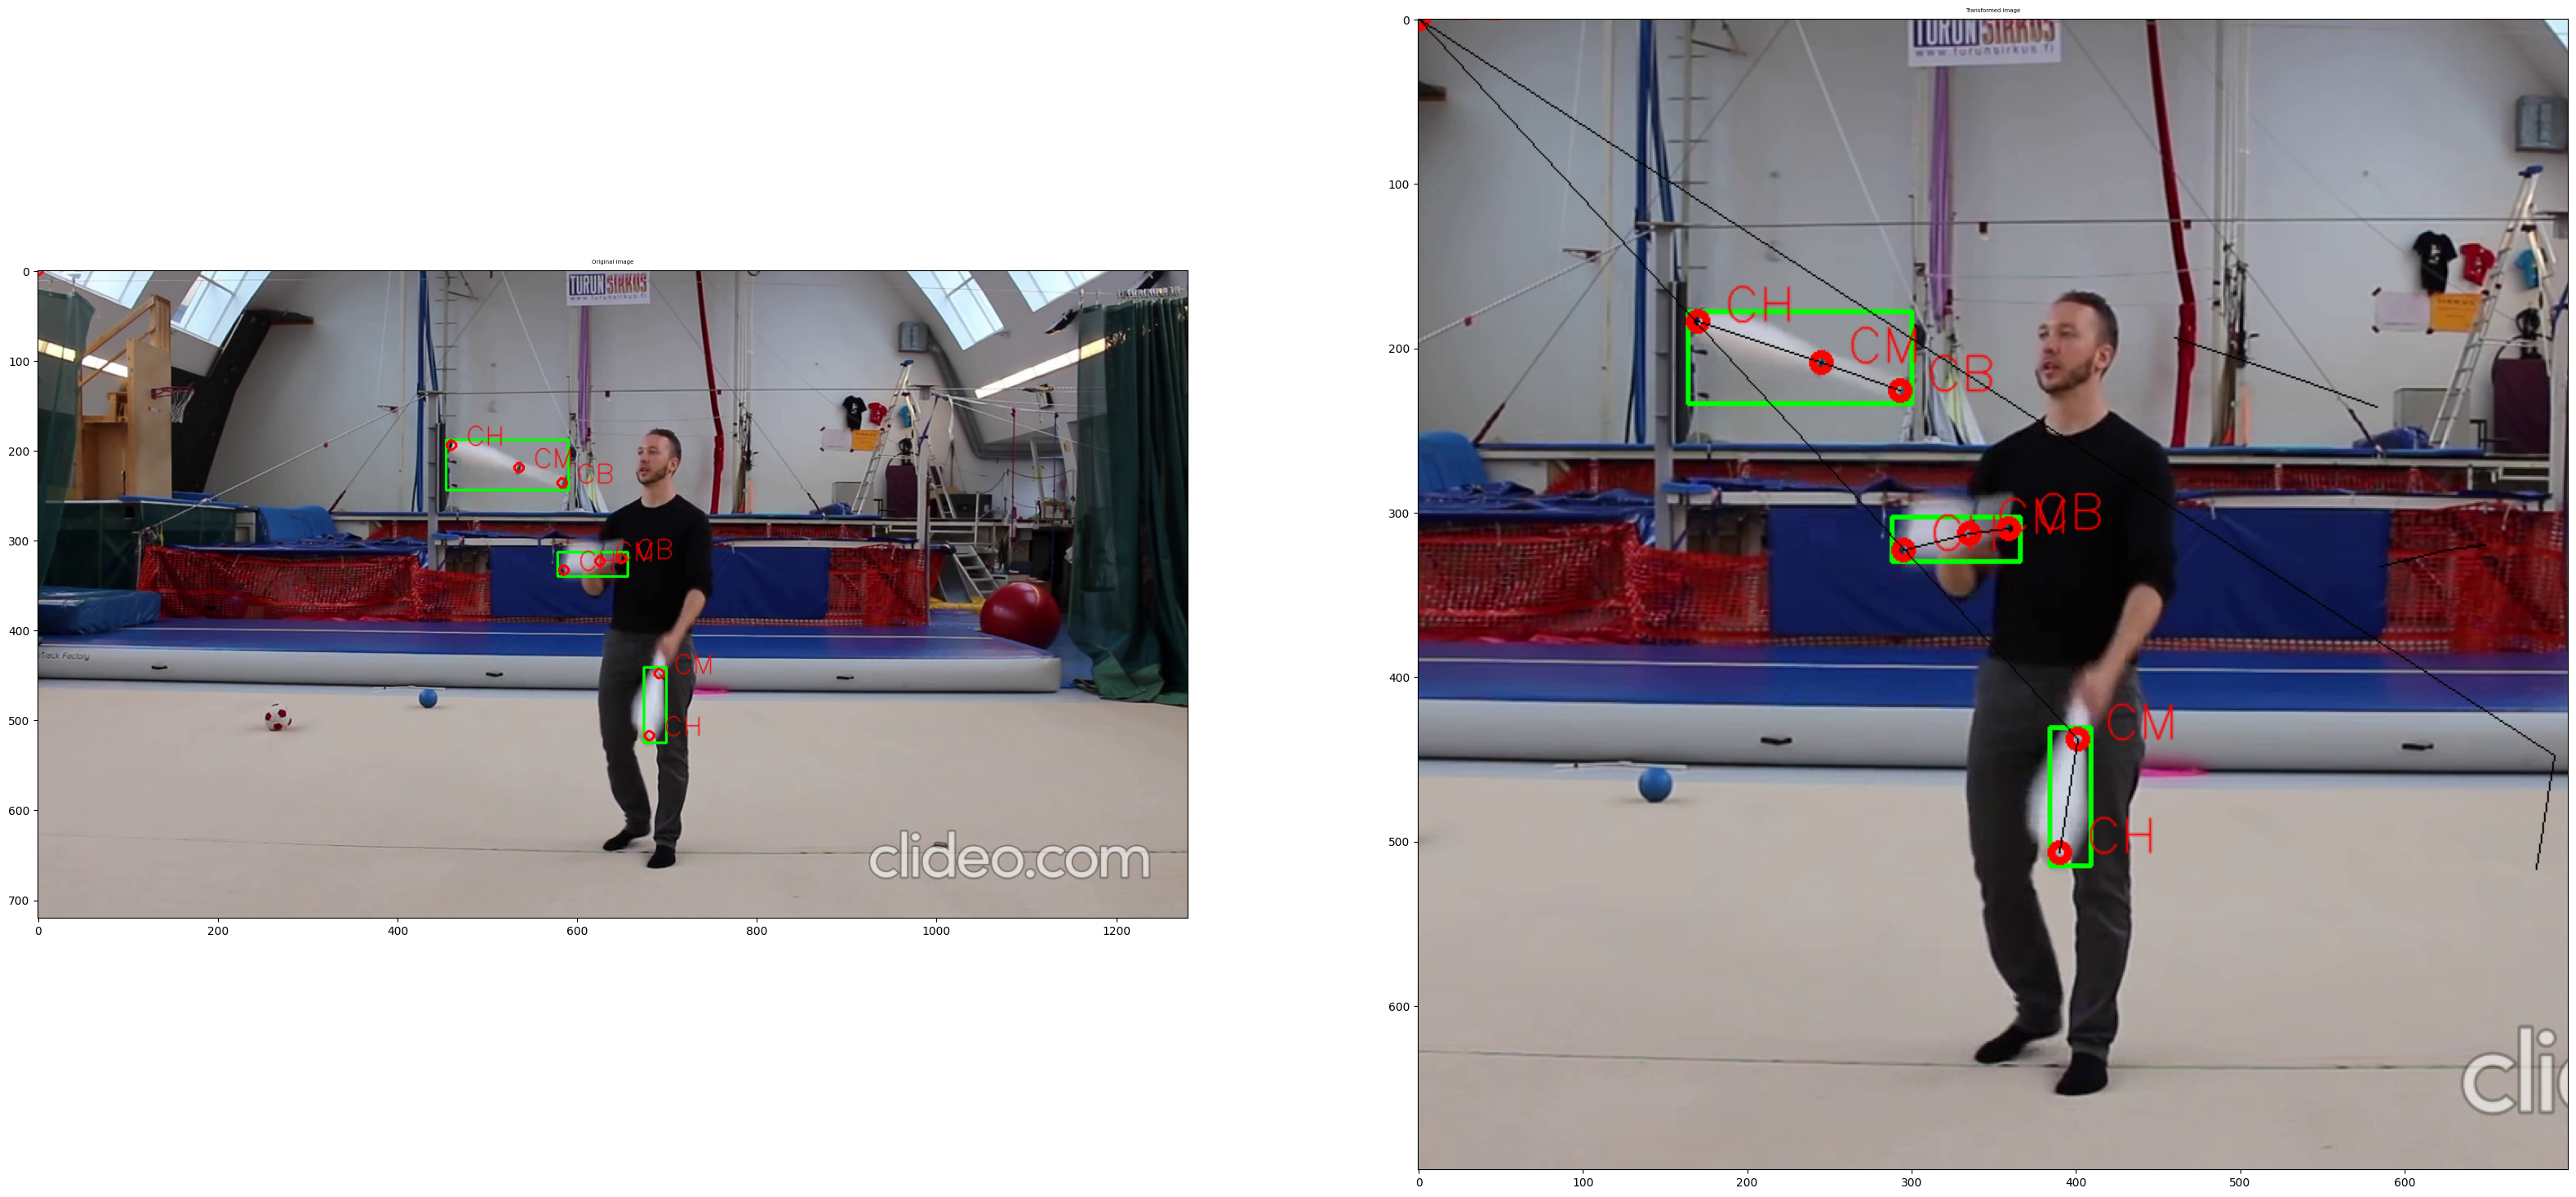

In [10]:
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

## Training and validation R-CNN

In [9]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0)) # object with specified anchor sizes and aspect ratios.
    
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False, # he detection head (the part responsible for object detection and keypoint prediction) will be initialized with random weights
                                                                   pretrained_backbone=True, #backbone network (ResNet-50) will be initialized with pre-trained weights from ImageNet
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   trainable_backbone_layers = 5,
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER = r"C:\Users\mcossin\Documents\object_detection\GitHub\Club_keypoint_Detection\Dataset4"

batch_size = 4

dataset_train = ClassDataset(KEYPOINTS_FOLDER,"train.json", transform=train_transform(), demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER, "valid.json", transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER,"test.json", transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [10]:
model = get_model(num_keypoints = 3)
model.to(device)
model_without_ddp = model

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, betas = (0.9, 0.999),eps = 1e-8, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.6)
# step_size (int): Period of learning rate decay.
# gamma (float): Multiplicative factor of learning rate decay. Default: 0.1.

start_epoch = 0
num_epochs = 20

amp = False #Automatic Mixed Precision, une fonctionnalité fournie par la bibliothèque PyTorch 
           #pour accélérer l'entraînement des réseaux de neurones en utilisant un mélange de précision simple 
           #(float16) et double (float32) pour les calculs.

output_dir = r"C:\Users\mcossin\Documents\object_detection\GitHub\Club_keypoint_Detection\Experiences\Exp10"

scaler = torch.cuda.amp.GradScaler() if amp else None

csv_path = os.path.join(output_dir,'loss.csv')

c:\Users\mcossin\.conda\envs\obj_detect\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mcossin\.conda\envs\obj_detect\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\mcossin\.conda\envs\obj_detect\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
c:\Users\mcossin\.conda\envs\obj_detect\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 

#### Charger un checkpoint

In [ ]:
checkpoint_path= r"C:\Users\mcossin\Documents\object_detection\code_detection\GitHub\Club_keypoint_Detection\Experiences\Exp17\model_19_baseline.pth"

model_to_retrain = os.path.join(output_dir,'model_19_baseline.pth')
model = get_model(num_keypoints = 3, weights_path=model_to_retrain)

num_epochs = 10

#### Training + validation

In [ ]:
print("Start training")
start_time = time.time()
for epoch in range(start_epoch, num_epochs):
    metric_logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1,csv_path = csv_path, scaler = scaler)
    lr_scheduler.step()
    #enregistre toutes les 5 epochs
    if (epoch + 1) % 5 == 0:

        torch.save(model.state_dict(), os.path.join(output_dir, f"model_{epoch}_baseline.pth"))


    # evaluate after every epoch
    evaluate(model, data_loader_val, device=device)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

In [ ]:
loss = pd.read_csv(csv_path,header = None)

loss = loss[0].str[7:13]
loss= loss.astype(float)

num_iters_per_epoch = len(dataset_train) // batch_size

loss_epoch = [l for i, l in enumerate(loss) if i % (num_iters_per_epoch + 1) == 0]

epoch_list = range(num_epochs)

In [ ]:
plt.plot(loss.index, loss)
plt.xlabel("Iteration")
plt.ylabel("Train Loss")
plt.title("Loss Curve")
plt.show()

In [ ]:
plt.plot(epoch_list, loss_epoch[2:])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Loss Curve by epoch")
plt.show()

#### Test

In [11]:
# evaluate after training and validation are finished

model_to_test = os.path.join(output_dir,'model_19_baseline.pth')
model = get_model(num_keypoints = 3, weights_path=model_to_test)
print("\nStart testing")
coco_evaluator = evaluate(model, data_loader_test, device=device)

keypoints_eval_info = coco_evaluator.coco_eval['keypoints'].stats.tolist()
print("Validation Keypoints mAP progression: ", keypoints_eval_info[0])


Start testing
creating index...
index created!


AssertionError: Results do not correspond to current coco set

## Inference et visualisation

In [ ]:
# Charger le modèle entraîné
model_to_test = os.path.join(output_dir,'model_19_baseline.pth')
model = get_model(num_keypoints = 3, weights_path=model_to_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transférer le modèle sur l'appareil cible
model = model.to(device)

# Définir le modèle en mode d'évaluation
model.eval()

# Définir le chemin d'accès à la vidéo
video_path = r"C:\Users\mcossin\Documents\object_detection\Data\youtube_video\test\video-youtube-1_test.mp4"

# Ouvrir la vidéo avec OpenCV
cap = cv2.VideoCapture(0) 

fc = 0
fps = 0
tfc = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
tfcc = 0

print(f"Total frame count : {tfc}")

# Lire la vidéo image par image
while tfcc < tfc:

    start_time = time.time()

    # Lire une image de la vidéo
    ret, frame = cap.read()

    # Si la fin de la vidéo est atteinte, sortir de la boucle
    if not ret:
        break

    # Convertir l'image en tenseur PyTorch
    image = torch.from_numpy(frame).permute(2, 0, 1).float().unsqueeze(0) / 255
    #image = (frame.permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    image = image.to(device)

    # Effectuer une prédiction avec le modèle
    with torch.no_grad():
        output = model(image)

    # Extraire les prédictions de la sortie du modèle
    scores = output[0]['scores'].detach().cpu().numpy()
    high_scores_idxs = np.where(scores > 0.7)[0].tolist()
    post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy()

    keypoints = []
    for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        keypoints.append([list(map(int, kp[:2])) for kp in kps])

    bboxes = []
    for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        bboxes.append(list(map(int, bbox.tolist())))

    # Visualiser les prédictions sur l'image
    frame = visualize(frame, bboxes, keypoints)

    # Écrire l'image avec les prédictions dans le fichier de sortie
    out.write(frame)

    # Calculer le FPS
    fc += 1
    end_time = time.time()
    fps += 1/np.round(end_time - start_time, 3)
    if fc == 10:
        fps = int(fps / 10)
        tfcc += fc
        fc = 0
        per_com = int(tfcc / tfc * 100)
        print(f"Frames Per Second : {fps} || Percentage Parsed : {per_com}")
        start_time = end_time

# Libérer les ressources OpenCV
cap.release()
out.release()
cv2.destroyAllWindows()

#### Inference on Real Time

In [ ]:
#https://pytorch.org/tutorials/intermediate/realtime_rpi.html
# Charger le modèle entraîné
model_to_test = os.path.join(output_dir,'model_19_baseline.pth')
model = get_model(num_keypoints = 3, weights_path=model_to_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transférer le modèle sur l'appareil cible
model = model.to(device)

# Définir le modèle en mode d'évaluation
model.eval()

# Ouvrir la vidéo avec OpenCV
cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 224)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 224)
cap.set(cv2.CAP_PROP_FPS, 36)

# Lire la largeur et la hauteur de la vidéo
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Définir le codec et le fichier de sortie pour enregistrer la vidéo avec les prédictions
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_file = os.path.join(r"C:\Users\mcossin\Documents\object_detection\Data\youtube_video\video_inference",'video.mp4')
out = cv2.VideoWriter(out_file, fourcc, 20.0, (width, height))

start_time = time.time()
frame_count = 0
last_logged = time.time()

print(f"Total frame count : {tfc}")

# Lire la vidéo image par image
while True:

    # Lire une image de la vidéo
    ret, frame = cap.read()

    # Si la fin de la vidéo est atteinte, sortir de la boucle
    if not ret:
        break

    # Convertir l'image en tenseur PyTorch
    image = torch.from_numpy(frame).permute(2, 0, 1).float().unsqueeze(0) / 255
    #image = (frame.permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    image = image.to(device)

    # Effectuer une prédiction avec le modèle
    with torch.no_grad():
        output = model(image)

    # Extraire les prédictions de la sortie du modèle
    scores = output[0]['scores'].detach().cpu().numpy()
    high_scores_idxs = np.where(scores > 0.7)[0].tolist()
    post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy()

    keypoints = []
    for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        keypoints.append([list(map(int, kp[:2])) for kp in kps])

    bboxes = []
    for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        bboxes.append(list(map(int, bbox.tolist())))

    # Visualiser les prédictions sur l'image
    frame = visualize(frame, bboxes, keypoints)

    # Écrire l'image avec les prédictions dans le fichier de sortie
    out.write(frame)

    cv2.imshow('Frame', frame)

    # Attendre 1 milliseconde pour permettre à l'utilisateur de fermer la fenêtre
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_count += 1
    now = time.time()
    if now - last_logged > 1:
        print(f"{frame_count / (now-last_logged)} fps")
        last_logged = now
        frame_count = 0

# Libérer les ressources OpenCV
cap.release()
out.release()
cv2.destroyAllWindows()

#### 1 image test

In [ ]:
iterator = iter(data_loader_test)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

In [ ]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

#### Toutes les images test

In [ ]:
for i, (images, targets) in enumerate(data_loader_test):
    images = list(image.to(device) for image in images)

    with torch.no_grad():
        output = model(images)

    for j, image in enumerate(images):
        image = (image.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)

        scores = output[j]['scores'].detach().cpu().numpy()
        high_scores_idxs = np.where(scores > 0.7)[0].tolist()
        post_nms_idxs = torchvision.ops.nms(output[j]['boxes'][high_scores_idxs], output[j]['scores'][high_scores_idxs], 0.3).cpu().numpy()

        keypoints = []
        for kps in output[j]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[j]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))

        print(f"Predictions for Batch {i + 1}, Image {j + 1}:")
        print("Bounding boxes:", bboxes)
        print("Keypoints:", keypoints)

        visualize(image, bboxes, keypoints)